# Fractional Fluxes


### Caltech Summer 2019

Adapted from the HBC 722 Updated notebook. Started 25 March 2020.

### Imports 

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from scipy import signal
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct11 import *
from fu_ori_classes_oct11 import *
import matplotlib.gridspec as gridspec
from PyAstronomy import pyasl
import spectres

### Constants (astronomy is in cgs, right?)

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

In [3]:
DIREC = '/Users/tonyrodriguez/Documents/Docs/2019 Summer/Stellar Atmospheres/'

In [4]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [5]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [6]:
direcToArray(DIREC)

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

## Making an instance of the class FU Ori and testing

In [7]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_spec, wave_upper_spec, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_spec = wave_lower_spec
        self.wave_upper_spec = wave_upper_spec
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = []
        self.rot_star = 0
        self.disk_atm = []
        
        print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc, atm_table):
        print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
        print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 200, 1*r_star)
        print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, model='stellar atmospheres')
        print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
                            binning=1, broaden=True, interp_type='linear')
        print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=True)
        print('FU Ori object created.')
        self.fuori.append(fuori)
    
    # Creating rotating star
    def createRotStar(self, temp, r_star, m_star, inc, a_v, dist, grav, direc, atm_table):
        self.rot_star = Star(temp, grav, m_star, r_star, direc, np.radians(inc), a_v, atm_table) 
        self.rot_star.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        self.rot_star.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 1, 'linear')
        self.rot_star.broadenStellarSpectrum()
        
    def createDiskAtm(self, temp, grav, vsini, direc, atm_table):
        disk_atm = DiskAtmosphere(temp, grav, vsini, direc, atm_table) 
        disk_atm.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        disk_atm.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 1, 'linear')
        disk_atm.broadenDiskAtmSpectrum()
        self.disk_atm.append(disk_atm)
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, obj_type, obj_num, broaden, redden):
        if obj_type == 'fu ori':
            return self.fuori[obj_num].viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'rotating star':
            return self.rot_star.getLuminosity(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'disk atmosphere':
            return self.disk_atm[obj_num].getLuminosity(wave_lower, wave_upper, 'broadened')
    
    # For viewing model SED
    def viewModelSED(self, wave_lower, wave_upper, broaden):
        waves, lums = self.fuori.viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        return np.log10(waves*1e-4), np.log10(np.cos(np.radians(self.inc))*waves*1e-8*lums/(2*np.pi*(self.dist**2)))

    # Useful modules
    def viewFracLums(self, wave_lower, wave_upper, obj_num, data_type, x_axis_type):
        return self.fuori[obj_num].calculateFracLums(wave_lower, wave_upper, data_type, x_axis_type)
    
    def viewGravComparison(self, obj_nums, wave_lower, wave_upper, broaden, redden):
        obj_n1, obj_n2 = obj_nums
        wav, lum1 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n1, broaden, redden)
        wav, lum2 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n2, broaden, redden)
        lum_diff = np.abs(lum2 - lum1)
        return wav, lum_diff    

In [8]:
PARAMS = [0.70, 1.39, -5.50, 3.16, 30, 0] # HBC 722 Model 3
PARAMS_2 = [0.18, 0.36, -6.53, 3.52, 30, 0] # Gaia 17bpi Model 3
PARAMS = PARAMS_2

In [9]:
gaia17bpi_env = FUOriEnvironment(3.95e3, 4.55e3, 0, 0)
gaia17bpi_env2 = FUOriEnvironment(7.95e3, 8.55e3, 0, 0)
gaia17bpi_env3 = FUOriEnvironment(22.95e3, 23.55e3, 0, 0)
gaia17bpi_envNEW = FUOriEnvironment(4.95e3, 6.55e3, 0, 0)


R_OUTER = 100*R_SUN
DIST = 1.27e3*3.08567758128e18
# Spectrum fit
%time gaia17bpi_env.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * M_SUN / 3.154e7, inc = PARAMS[4],\
                                a_v = PARAMS[3],dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE)
%time gaia17bpi_env2.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * M_SUN / 3.154e7, inc = PARAMS[4],\
                                a_v = PARAMS[3],dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE)
%time gaia17bpi_env3.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * M_SUN / 3.154e7, inc = PARAMS[4],\
                                a_v = PARAMS[3],dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE)

%time gaia17bpi_envNEW.createFUOri(r_star = PARAMS[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS[0]*M_SUN,\
                          m_dot = (10**PARAMS[2]) * M_SUN / 3.154e7, inc = PARAMS[4],\
                                a_v = PARAMS[3],dist = DIST, grav = 1.5, \
                                direc = DIREC, atm_table=ATM_TABLE)
# %time gaia17bpi_envNEW2.createFUOri(r_star = PARAMS_2[1]*R_SUN, r_outer = R_OUTER, m_star = PARAMS_2[0]*M_SUN,\
#                           m_dot = (10**PARAMS_2[2]) * M_SUN / 3.154e7, inc = PARAMS_2[4],\
#                                 a_v = PARAMS_2[3],dist = DIST, grav = 1.5, \
#                                 direc = DIREC, atm_table=ATM_TABLE)




Created environment.
Created environment.
Created environment.
Created environment.
Creating FU Ori object...
Creating disk annuli...
Reading stellar atmosphere directory...
Used stellar atmosphere at T = 7600.
Used stellar atmosphere at T = 7400.
Used stellar atmosphere at T = 7200.
Used stellar atmosphere at T = 7000.
Used stellar atmosphere at T = 6800.
Used stellar atmosphere at T = 6600.
Used stellar atmosphere at T = 6400.
Used stellar atmosphere at T = 6200.
Used stellar atmosphere at T = 6000.
Used stellar atmosphere at T = 5800.
Used stellar atmosphere at T = 5600.
Used stellar atmosphere at T = 5400.
Used stellar atmosphere at T = 5200.
Used stellar atmosphere at T = 5000.
Used stellar atmosphere at T = 4800.
Used stellar atmosphere at T = 4600.
Used stellar atmosphere at T = 4400.
Used stellar atmosphere at T = 4200.
Used stellar atmosphere at T = 4000.
Used stellar atmosphere at T = 3800.
Used stellar atmosphere at T = 3600.
Used stellar atmosphere at T = 3400.
Used stellar

/Users/tonyrodriguez/Documents/Docs/2019 Summer/Jupyter Notebooks/fu_ori_functions_oct11.py:134: RuntimeWarning: overflow encountered in exp
  term2 = (np.exp(h_PLANCK*c_LIGHT/(wavelength*k_BOLTZ*temp))-1)**(-1)


No stellar atmosphere for annulus of T = 679. Used blackbody.
No stellar atmosphere for annulus of T = 671. Used blackbody.
No stellar atmosphere for annulus of T = 663. Used blackbody.
No stellar atmosphere for annulus of T = 656. Used blackbody.
No stellar atmosphere for annulus of T = 649. Used blackbody.
No stellar atmosphere for annulus of T = 642. Used blackbody.
No stellar atmosphere for annulus of T = 635. Used blackbody.
No stellar atmosphere for annulus of T = 628. Used blackbody.
No stellar atmosphere for annulus of T = 621. Used blackbody.
No stellar atmosphere for annulus of T = 615. Used blackbody.
No stellar atmosphere for annulus of T = 609. Used blackbody.
No stellar atmosphere for annulus of T = 603. Used blackbody.
No stellar atmosphere for annulus of T = 597. Used blackbody.
No stellar atmosphere for annulus of T = 591. Used blackbody.
No stellar atmosphere for annulus of T = 585. Used blackbody.
No stellar atmosphere for annulus of T = 580. Used blackbody.
No stell

No stellar atmosphere for annulus of T = 257. Used blackbody.
No stellar atmosphere for annulus of T = 256. Used blackbody.
No stellar atmosphere for annulus of T = 255. Used blackbody.
No stellar atmosphere for annulus of T = 254. Used blackbody.
No stellar atmosphere for annulus of T = 253. Used blackbody.
No stellar atmosphere for annulus of T = 253. Used blackbody.
No stellar atmosphere for annulus of T = 252. Used blackbody.
No stellar atmosphere for annulus of T = 251. Used blackbody.
No stellar atmosphere for annulus of T = 250. Used blackbody.
No stellar atmosphere for annulus of T = 250. Used blackbody.
No stellar atmosphere for annulus of T = 249. Used blackbody.
No stellar atmosphere for annulus of T = 248. Used blackbody.
No stellar atmosphere for annulus of T = 247. Used blackbody.
No stellar atmosphere for annulus of T = 246. Used blackbody.
No stellar atmosphere for annulus of T = 246. Used blackbody.
No stellar atmosphere for annulus of T = 245. Used blackbody.
No stell

No stellar atmosphere for annulus of T = 441. Used blackbody.
No stellar atmosphere for annulus of T = 438. Used blackbody.
No stellar atmosphere for annulus of T = 435. Used blackbody.
No stellar atmosphere for annulus of T = 432. Used blackbody.
No stellar atmosphere for annulus of T = 429. Used blackbody.
No stellar atmosphere for annulus of T = 427. Used blackbody.
No stellar atmosphere for annulus of T = 424. Used blackbody.
No stellar atmosphere for annulus of T = 421. Used blackbody.
No stellar atmosphere for annulus of T = 419. Used blackbody.
No stellar atmosphere for annulus of T = 416. Used blackbody.
No stellar atmosphere for annulus of T = 414. Used blackbody.
No stellar atmosphere for annulus of T = 411. Used blackbody.
No stellar atmosphere for annulus of T = 409. Used blackbody.
No stellar atmosphere for annulus of T = 406. Used blackbody.
No stellar atmosphere for annulus of T = 404. Used blackbody.
No stellar atmosphere for annulus of T = 402. Used blackbody.
No stell

No stellar atmosphere for annulus of T = 245. Used blackbody.
No stellar atmosphere for annulus of T = 244. Used blackbody.
No stellar atmosphere for annulus of T = 244. Used blackbody.
No stellar atmosphere for annulus of T = 243. Used blackbody.
No stellar atmosphere for annulus of T = 242. Used blackbody.
No stellar atmosphere for annulus of T = 241. Used blackbody.
No stellar atmosphere for annulus of T = 241. Used blackbody.
No stellar atmosphere for annulus of T = 240. Used blackbody.
No stellar atmosphere for annulus of T = 239. Used blackbody.
No stellar atmosphere for annulus of T = 239. Used blackbody.
No stellar atmosphere for annulus of T = 238. Used blackbody.
No stellar atmosphere for annulus of T = 237. Used blackbody.
No stellar atmosphere for annulus of T = 237. Used blackbody.
No stellar atmosphere for annulus of T = 236. Used blackbody.
No stellar atmosphere for annulus of T = 235. Used blackbody.
No stellar atmosphere for annulus of T = 235. Used blackbody.
No stell

No stellar atmosphere for annulus of T = 456. Used blackbody.
No stellar atmosphere for annulus of T = 453. Used blackbody.
No stellar atmosphere for annulus of T = 449. Used blackbody.
No stellar atmosphere for annulus of T = 446. Used blackbody.
No stellar atmosphere for annulus of T = 444. Used blackbody.
No stellar atmosphere for annulus of T = 441. Used blackbody.
No stellar atmosphere for annulus of T = 438. Used blackbody.
No stellar atmosphere for annulus of T = 435. Used blackbody.
No stellar atmosphere for annulus of T = 432. Used blackbody.
No stellar atmosphere for annulus of T = 429. Used blackbody.
No stellar atmosphere for annulus of T = 427. Used blackbody.
No stellar atmosphere for annulus of T = 424. Used blackbody.
No stellar atmosphere for annulus of T = 421. Used blackbody.
No stellar atmosphere for annulus of T = 419. Used blackbody.
No stellar atmosphere for annulus of T = 416. Used blackbody.
No stellar atmosphere for annulus of T = 414. Used blackbody.
No stell

No stellar atmosphere for annulus of T = 244. Used blackbody.
No stellar atmosphere for annulus of T = 244. Used blackbody.
No stellar atmosphere for annulus of T = 243. Used blackbody.
No stellar atmosphere for annulus of T = 242. Used blackbody.
No stellar atmosphere for annulus of T = 241. Used blackbody.
No stellar atmosphere for annulus of T = 241. Used blackbody.
No stellar atmosphere for annulus of T = 240. Used blackbody.
No stellar atmosphere for annulus of T = 239. Used blackbody.
No stellar atmosphere for annulus of T = 239. Used blackbody.
No stellar atmosphere for annulus of T = 238. Used blackbody.
No stellar atmosphere for annulus of T = 237. Used blackbody.
No stellar atmosphere for annulus of T = 237. Used blackbody.
No stellar atmosphere for annulus of T = 236. Used blackbody.
No stellar atmosphere for annulus of T = 235. Used blackbody.
No stellar atmosphere for annulus of T = 235. Used blackbody.
No stellar atmosphere for annulus of T = 234. Used blackbody.
No stell

No stellar atmosphere for annulus of T = 419. Used blackbody.
No stellar atmosphere for annulus of T = 416. Used blackbody.
No stellar atmosphere for annulus of T = 414. Used blackbody.
No stellar atmosphere for annulus of T = 411. Used blackbody.
No stellar atmosphere for annulus of T = 409. Used blackbody.
No stellar atmosphere for annulus of T = 406. Used blackbody.
No stellar atmosphere for annulus of T = 404. Used blackbody.
No stellar atmosphere for annulus of T = 402. Used blackbody.
No stellar atmosphere for annulus of T = 399. Used blackbody.
No stellar atmosphere for annulus of T = 397. Used blackbody.
No stellar atmosphere for annulus of T = 395. Used blackbody.
No stellar atmosphere for annulus of T = 393. Used blackbody.
No stellar atmosphere for annulus of T = 390. Used blackbody.
No stellar atmosphere for annulus of T = 388. Used blackbody.
No stellar atmosphere for annulus of T = 386. Used blackbody.
No stellar atmosphere for annulus of T = 384. Used blackbody.
No stell

Annuli prepared from 4950-6550 Angstrom with binning of 1 Angstrom. Broadening implemented.
Creating model spectrum...
FU Ori object created.
CPU times: user 15.7 s, sys: 130 ms, total: 15.9 s
Wall time: 15.9 s


## Fractional Fluxes

In [10]:
temp, frac_lums = gaia17bpi_env.viewFracLums(4.0e3, 4.1e3, 0, 'broadened', 'temperature')
temp2, frac_lums2 = gaia17bpi_env.viewFracLums(4.4e3, 4.5e3, 0, 'broadened', 'temperature')
temp3, frac_lums3 = gaia17bpi_env2.viewFracLums(8.0e3, 8.1e3, 0, 'broadened', 'temperature')
temp4, frac_lums4 = gaia17bpi_env2.viewFracLums(8.4e3, 8.5e3, 0, 'broadened', 'temperature')
temp5, frac_lums5 = gaia17bpi_env3.viewFracLums(23.0e3, 23.1e3, 0, 'broadened', 'temperature')
temp6, frac_lums6 = gaia17bpi_env3.viewFracLums(23.4e3, 23.5e3, 0, 'broadened', 'temperature')

temp7, frac_lums7 = gaia17bpi_envNEW.viewFracLums(5.0e3, 6.5e3, 0, 'broadened', 'temperature')

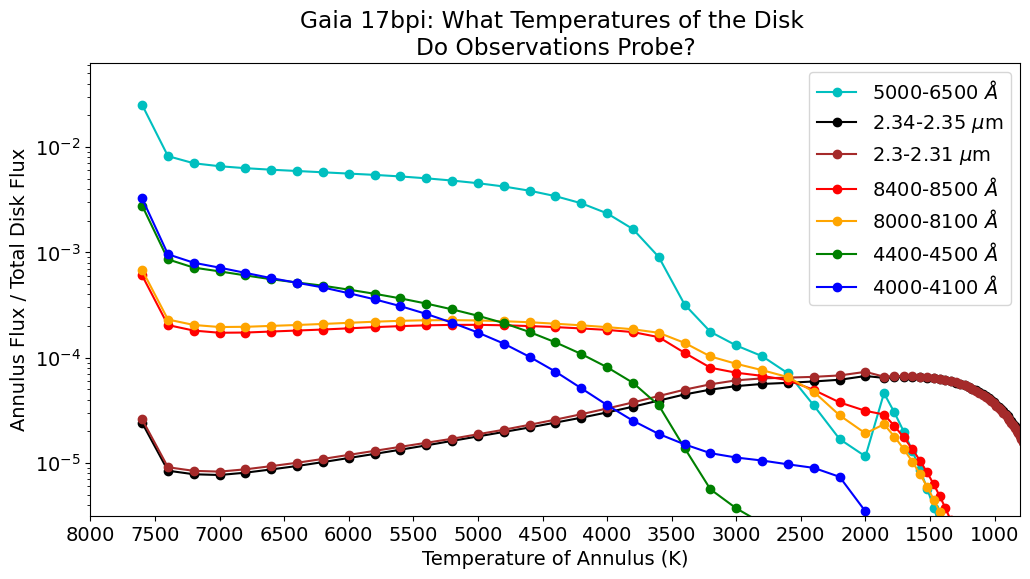

In [13]:
fig=plt.figure(figsize=(12, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.title('Gaia 17bpi: What Temperatures of the Disk \nDo Observations Probe?')
plt.ylabel('Annulus Flux / Total Disk Flux')
plt.xlabel('Temperature of Annulus (K)')

plt.semilogy(temp7, frac_lums7, 'co-', label=r'5000-6500 $\AA$')


plt.semilogy(temp6, frac_lums6, 'ko-', label=r'2.34-2.35 $\mu$m')
plt.semilogy(temp5, frac_lums5, 'o-', color = 'brown', label=r'2.3-2.31 $\mu$m')
plt.semilogy(temp4, frac_lums4, 'o-',color='red', label=r'8400-8500 $\AA$')
plt.semilogy(temp3, frac_lums3, 'o-',color='orange', label=r'8000-8100 $\AA$')
plt.semilogy(temp2, frac_lums2, 'go-', label=r'4400-4500 $\AA$')
plt.semilogy(temp, frac_lums, 'bo-', label=r'4000-4100 $\AA$')


plt.xlim(gaia17bpi_env.fuori[0].annuli[0].temp+100, 800)
plt.xticks(np.arange(1000, gaia17bpi_env.fuori[0].annuli[0].temp + 500, 500))
plt.ylim(10**(-5.5), 10**(-1.2))
plt.legend()
# plt.savefig('gaia17bpi_fracflux_temp.png', dpi=200, bbox_inches='tight')
plt.show()

In [13]:
rad, frac_lums = gaia17bpi_env.viewFracLums(4.0e3, 4.1e3, 0, 'broadened', 'distance')
rad2, frac_lums2 = gaia17bpi_env.viewFracLums(4.4e3, 4.5e3, 0, 'broadened', 'distance')
rad3, frac_lums3 = gaia17bpi_env2.viewFracLums(8.0e3, 8.1e3, 0, 'broadened', 'distance')
rad4, frac_lums4 = gaia17bpi_env2.viewFracLums(8.4e3, 8.5e3, 0, 'broadened', 'distance')
rad5, frac_lums5 = gaia17bpi_env3.viewFracLums(23.0e3, 23.1e3, 0, 'broadened', 'distance')
rad6, frac_lums6 = gaia17bpi_env3.viewFracLums(23.4e3, 23.5e3, 0, 'broadened', 'distance')

In [14]:
def tick_function(r):
    
    return ["%.3f" % z for z in temp]

In [15]:
temp[32]

1637.6834674414501

In [16]:
TICK_INDS = [0, 5, 10, 15, 20, 25, 32]

/Users/tonyrodriguez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


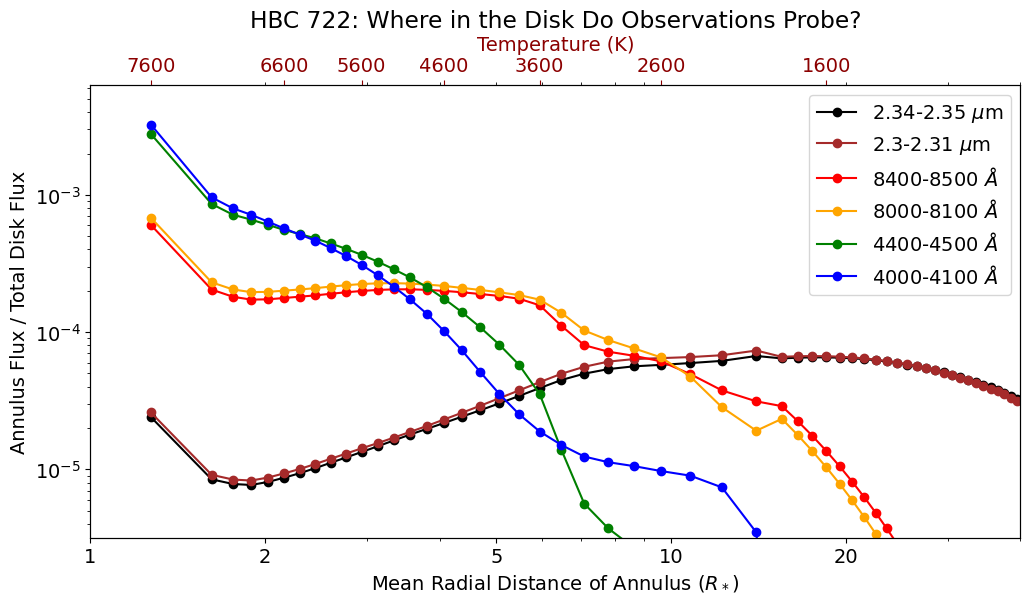

In [17]:
fig=plt.figure(figsize=(12, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.title('HBC 722: Where in the Disk Do Observations Probe?')
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xscale('log')

ax1.loglog(rad6, frac_lums6, 'ko-', label=r'2.34-2.35 $\mu$m')
ax1.loglog(rad5, frac_lums5,  'o-', color = 'brown', label=r'2.3-2.31 $\mu$m')
ax1.loglog(rad4, frac_lums4,  'o-',color='red', label=r'8400-8500 $\AA$')
ax1.loglog(rad3, frac_lums3, 'o-',color='orange', label=r'8000-8100 $\AA$')
ax1.loglog(rad2, frac_lums2, 'go-', label=r'4400-4500 $\AA$')
ax1.loglog(rad, frac_lums,  'bo-', label=r'4000-4100 $\AA$')


ax1.set_xticks([1, 2, 5, 10, 20])
ax1.set_xticklabels([1, 2, 5, 10, 20])

ax1.set_ylabel('Annulus Flux / Total Disk Flux')
ax1.set_xlabel(r'Mean Radial Distance of Annulus ($R_*$)')
ax2.set_xlabel(r'Temperature (K)', color= 'darkred')



ax2.set_xticks([rad[i] for i in TICK_INDS])
ax2.set_xticklabels([str(int(temp[i]/100)*100) for i in TICK_INDS])

ax1.set_xlim(1, 40)
ax2.set_xlim(1, 40)
ax2.tick_params(axis='x', colors='darkred')

ax1.set_ylim(10**(-5.5), 10**(-2.2))
ax1.legend()

# plt.savefig('hbc722_fracflux.png', dpi=200, bbox_inches='tight')
plt.show()

### New tool

In [30]:
def waveSpeedPlot(wave_start, wave_stop, wave_step, obj):
    rads, fracs, temps, fracs_temps = [], [], [], []
    wave_list = np.arange(wave_start, wave_stop, wave_step)
    for i in range(len(wave_list)-1):
        rads.append(obj.viewFracLums(wave_list[i], wave_list[i+1], 0, 'interpolated', 'distance')[0])
        fracs.append(obj.viewFracLums(wave_list[i], wave_list[i+1], 0, 'interpolated', 'distance')[1])
        temps.append(obj.viewFracLums(wave_list[i], wave_list[i+1], 0, 'interpolated', 'temperature')[0])
        fracs_temps.append(obj.viewFracLums(wave_list[i], wave_list[i+1], 0, 'interpolated', 'temperature')[1])
    return rads, fracs, temps, fracs_temps
    

In [31]:
rads, fracs, temps, fracs_temps = waveSpeedPlot(1e3, 26e3, 200, gaia17bpi_envNEW)
# rads2, fracs2, temps2, fracs_temps2 = waveSpeedPlot(1e3, 26e3, 200, gaia17bpi_envNEW2)


actual_mass = gaia17bpi_envNEW.fuori[0].m_star
actual_rad = gaia17bpi_envNEW.fuori[0].r_star

# actual_mass2 = gaia17bpi_envNEW2.fuori[0].m_star
# actual_rad2 = gaia17bpi_envNEW2.fuori[0].r_star

In [32]:
actual_rad/R_SUN, actual_rad2/R_SUN

NameError: name 'actual_rad2' is not defined

In [86]:
VEL_STAR = 40e5
VEL_STAR2 = 10e5
EPSILON = 0.25
INC = 30

In [87]:
def averagingPlot(rads, fracs, temps, fracs_temps, m_star, r_star, vel_star):
    vels_kep = np.sqrt(G*m_star/(r_star*np.array(rads)))
    vel_0 = vel_star*np.ones(np.shape(vels_kep))
    vels = vels_kep - EPSILON*(vels_kep-vel_0)*(1/np.array(rads))**2
    avg_speeds = []
    avg_speeds_kep = []
    avg_temps = []
    # Doing it for radii
    for i in range(len(rads)):
        avg_speeds.append(np.average(vels[i]*1e-5, weights=fracs[i]))
        avg_speeds_kep.append(np.average(vels_kep[i]*1e-5, weights=fracs[i]))

    # Doing it for temps
    for i in range(len(temps)):
        avg_temps.append(np.average(temps[i], weights=fracs_temps[i]))
    return avg_speeds, avg_speeds_kep, avg_temps

In [88]:
avg_speeds, avg_speeds_kep, avg_temps = \
averagingPlot(rads, fracs, temps, fracs_temps, actual_mass, actual_rad, VEL_STAR)

avg_speeds2, avg_speeds_kep2, avg_temps2 = \
averagingPlot(rads, fracs, temps, fracs_temps, actual_mass, actual_rad, VEL_STAR2)


# avg_speeds2, avg_speeds_kep2, avg_temps2\
# = averagingPlot(rads2, fracs2, temps2, fracs_temps2, actual_mass2, actual_rad2)

### Reading in velocity data points

In [89]:
data_vel = 'hbc722_vmax_obs.txt'

In [90]:
f = open(data_vel)
lines = f.readlines()

wav_data, vel_data = [], []

for line in lines:
    l = line.split()
    wav_data.append(l[0])
    vel_data.append(l[1])
f.close()




In [91]:
wav_data = np.array(wav_data[1:], dtype='float')
vel_data = np.array(vel_data[1:], dtype='float')

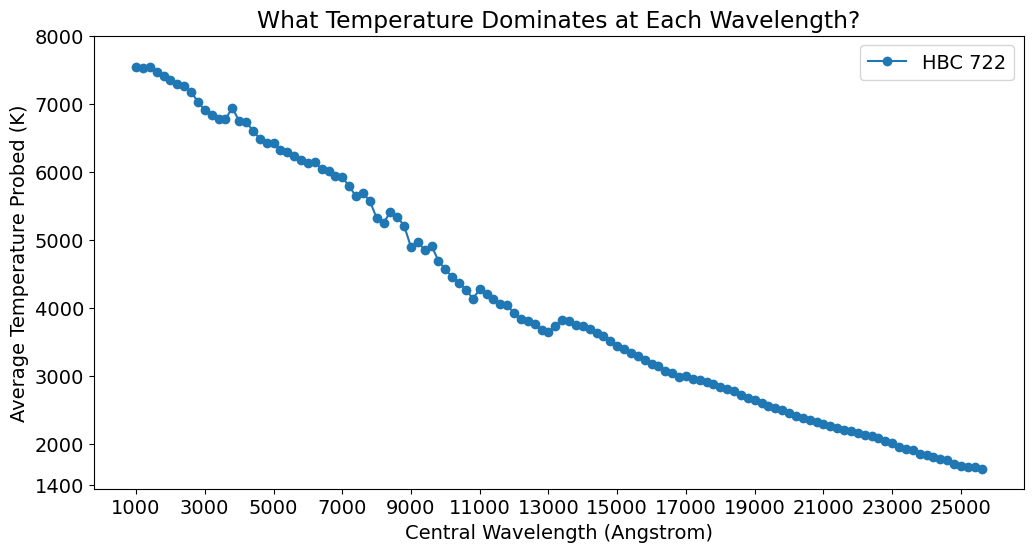

In [92]:
fig=plt.figure(figsize=(12, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.title('What Temperature Dominates at Each Wavelength?')

plt.plot(np.arange(1e3, 26e3-200, 200),np.array(avg_temps), 'o-', label = r'HBC 722')
# plt.plot(np.arange(1e3, 26e3-200, 200),np.array(avg_temps2), 'o-', label = r'Gaia 17bpi')


# plt.plot(wav_data, vel_data, 'ro')

plt.xlabel('Central Wavelength (Angstrom)')
plt.ylabel('Average Temperature Probed (K)')
plt.xticks(np.arange(1e3, 26e3, 2000))
plt.yticks([1400, 2000, 3000, 4000, 5000, 6000, 7000, 8000])
# plt.axvspan(3900, 21000, color='green', alpha=0.1, label='Optical + NIR')
plt.legend()
# plt.savefig('temp_plot', bbox_inches='tight')
plt.show()

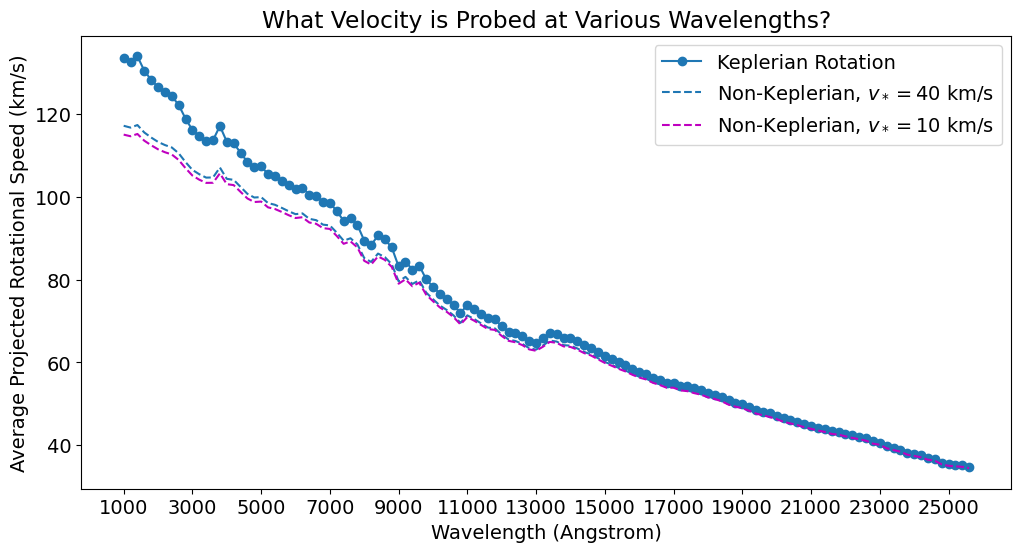

In [93]:
fig=plt.figure(figsize=(12, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.title('What Velocity is Probed at Various Wavelengths?')

plt.plot(np.arange(1e3, 26e3-200, 200),np.array(avg_speeds_kep)*np.sin(np.radians(INC)), 'o-', \
         color = 'tab:blue',label='Keplerian Rotation')
plt.plot(np.arange(1e3, 26e3-200, 200), np.array(avg_speeds)*np.sin(np.radians(INC)), ls='dashed', \
         color = 'tab:blue', label=r'Non-Keplerian, $v_* = 40$ km/s')
plt.plot(np.arange(1e3, 26e3-200, 200), np.array(avg_speeds2)*np.sin(np.radians(INC)), ls='dashed', \
         color = 'm', label=r'Non-Keplerian, $v_* = 10$ km/s')

# plt.plot(np.arange(1e3, 23e3-200, 200),np.array(avg_speeds_kep2)*np.sin(np.radians(INC)), 'o-', \
#          color = 'tab:orange',label='Keplerian')
# plt.plot(np.arange(1e3, 23e3-200, 200), np.array(avg_speeds2)*np.sin(np.radians(INC)), ls='dashed', \
#          color = 'tab:orange', label=r'Non-Keplerian, $v_* = 40$ km/s ')
# plt.plot(wav_data, vel_data, 'ro')

plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Average Projected Rotational Speed (km/s)')
plt.xticks(np.arange(1e3, 26e3, 2000))
# plt.axvspan(4750, 4850, color='green', alpha=0.2)
plt.legend()
plt.savefig('vel_plot', bbox_inches='tight')
plt.show()